In [1]:
import numpy as np
import pandas as pd
from datetime import datetime 
from IPython.display import display, HTML

import shap
shap.initjs()

from fairlearn.reductions import ExponentiatedGradient
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

X, Y = shap.datasets.adult()
sensitive_attribute = 'Sex'

A = X[sensitive_attribute]
X = pd.get_dummies(X)

sc = StandardScaler()
X_scaled = sc.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

le = LabelEncoder()
Y = le.fit_transform(Y)

X = X.reset_index(drop=True)
A = A.reset_index(drop=True)

X_train = pd.DataFrame(X)
A_train = pd.Series(A)
y_train = pd.Series(Y)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)

# Keep the complete dataset for grid search
X_train_all = X_train
y_train_all = y_train
A_train_all = A_train

# Subsampling process
subsampling = all_train.sample(frac=0.3)
subsampling = subsampling.reset_index()
subsampling = subsampling.drop(columns=['index'])
tmp = subsampling.iloc[:, :-1]
A_train = subsampling.iloc[:, -1]
X_train = tmp.iloc[:, :-1]
y_train = tmp.iloc[:,-1]
all_train = pd.concat([X_train, y_train, A_train], axis=1)

display(all_train)


Bad key "text.kerning_factor" on line 4 in
/Users/parulgupta/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,0,Sex
0,21.0,4,10.0,4,12,3,4,0,0.0,0.0,20.0,39,0,0
1,25.0,2,14.0,4,10,3,4,1,0.0,0.0,20.0,39,0,1
2,21.0,4,2.0,2,8,2,4,1,0.0,0.0,40.0,9,0,1
3,62.0,4,10.0,2,4,4,4,1,0.0,0.0,40.0,39,0,1
4,31.0,2,9.0,0,11,0,4,1,0.0,0.0,47.0,39,1,1
5,35.0,6,9.0,2,5,4,4,1,0.0,0.0,80.0,39,1,1
6,25.0,4,13.0,0,10,0,4,0,0.0,0.0,44.0,39,0,0
7,32.0,4,15.0,2,12,4,4,1,4508.0,0.0,40.0,0,0,1
8,45.0,4,13.0,4,10,3,4,1,0.0,0.0,40.0,39,0,1
9,53.0,5,13.0,2,12,4,4,1,0.0,0.0,45.0,39,1,1


In [2]:
from sklearn.linear_model import LogisticRegression
logistic_learner = LogisticRegression(solver='liblinear', fit_intercept=True)
logistic_learner.fit(X_train_all, y_train_all)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [3]:
from sklearn.ensemble import GradientBoostingClassifier
ensemble_learner = GradientBoostingClassifier()
ensemble_learner.fit(X_train_all,y_train_all)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [4]:
from sklearn.metrics import balanced_accuracy_score

def get_error(y,predicted_y):
    correct_y = (y == predicted_y)
    return 1 - sum(correct_y)/len(correct_y)

def get_balanced_accuracy_score(y,predicted_y):
    return balanced_accuracy_score(y,predicted_y)

In [5]:
logistic_y = pd.Series(logistic_learner.predict(X_train_all),name="logistic_learner_y")
error_logistic = [get_error(y_train_all,logistic_y)]
accuracy_logistic = [get_balanced_accuracy_score(y_train_all,logistic_y)]

ensemble_y = pd.Series(ensemble_learner.predict(X_train_all),name="ensemble_learner_y")
error_ensemble = [get_error(y_train_all,ensemble_y)]
accuracy_ensemble = [get_balanced_accuracy_score(y_train_all,ensemble_y)]

print("The error for logistic learner is:")
print(error_logistic)
print("The balanced accuracy score for logistic learner is:")
print(accuracy_logistic)
print("The error for gradient boosting learner is:")
print(error_ensemble)
print("The balanced accuracy score for gradient boosting learner is:")
print(accuracy_ensemble)


The error for logistic learner is:
[0.1586253493443076]
The balanced accuracy score for logistic learner is:
[0.7393489443713217]
The error for gradient boosting learner is:
[0.13064709314824485]
The balanced accuracy score for gradient boosting learner is:
[0.7846400176815173]


In [6]:
def get_violation(predict_y,A_test,label_name):
    violations = []
    predicted_and_sensitiveFeature = pd.concat([predict_y,A_test],axis=1)
    grouped =predicted_and_sensitiveFeature.groupby('Sex')
    counts_by_race = grouped[[label_name]].count()
    passed_by_race = grouped[[label_name]].sum()

    for i,group in enumerate(grouped.groups.keys()):
        violation_1 = passed_by_race[label_name][i] / counts_by_race[label_name][i]
        violation_2 = sum(predict_y) / len(predict_y)
        violations.append(abs(violation_1 - violation_2))
    violation = max(violations)
    return violation

In [7]:
violation_logistic = [get_violation(logistic_y,A_train_all,"logistic_learner_y")]
print("The violation for logistic learner is:")
print(violation_logistic)

violation_ensemble = [get_violation(ensemble_y,A_train_all,"ensemble_learner_y")]
print("The violation for gradient boosting learner is:")
print(violation_ensemble)

The violation for logistic learner is:
[0.12424042105058944]
The violation for gradient boosting learner is:
[0.11763440734082388]


In [8]:
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch, DemographicParity
import numpy as np

expgrad_error_logistic = []
expgrad_violation_logistic = []
expgrad_accuracy_logistic = []

expgrad_error_ensemble = []
expgrad_violation_ensemble = []
expgrad_accuracy_ensemble = []

eps_list = [0.01]

for eps in eps_list:
    # Definition of expgrad for logistic learner
    expgrad_X_logistic = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    # Definition of expgrad for gradient boosting
    expgrad_X_ensemble = ExponentiatedGradient(
    GradientBoostingClassifier(),
    constraints=DemographicParity(),
    eps=eps,
    nu=1e-6)
    
    a=datetime.now()  
    expgrad_X_logistic.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    time_expgrad_logistic = (b-a).seconds
    
    a=datetime.now()  
    expgrad_X_ensemble.fit(
    X_train,
    y_train,
    sensitive_features=A_train)
    b=datetime.now()
    time_expgrad_ensemble = (b-a).seconds
    
    expgrad_y_logistic = pd.Series(expgrad_X_logistic.predict(X_train),name="logistic_learner_y")
    error_expgrad_logistic = get_error(y_train,expgrad_y_logistic)
    expgrad_error_logistic.append(error_expgrad_logistic)
    acc_expgrad_logistic = get_balanced_accuracy_score(y_train,expgrad_y_logistic)
    expgrad_accuracy_logistic.append(acc_expgrad_logistic)
    
    expgrad_y_ensemble = pd.Series(expgrad_X_ensemble.predict(X_train),name="ensemble_learner_y")
    error_expgrad_ensemble = get_error(y_train,expgrad_y_ensemble)
    expgrad_error_ensemble.append(error_expgrad_ensemble)
    acc_expgrad_ensemble = get_balanced_accuracy_score(y_train,expgrad_y_ensemble)
    expgrad_accuracy_ensemble.append(acc_expgrad_ensemble)
    
    violation_expgrad_logistic = get_violation(expgrad_y_logistic,A_train,"logistic_learner_y")
    expgrad_violation_logistic.append(violation_expgrad_logistic)
    
    violation_expgrad_ensemble = get_violation(expgrad_y_ensemble,A_train,"ensemble_learner_y")
    expgrad_violation_ensemble.append(violation_expgrad_ensemble)

In [9]:
print("Logistic learner & violation:")
print(expgrad_error_logistic,expgrad_violation_logistic)
print("Gradient boosting learner & violation:")
print(expgrad_error_ensemble,expgrad_violation_ensemble)

Logistic learner & violation:
[0.1738329238329238] [0.0103391184851859]
Gradient boosting learner & violation:
[0.13953726453726456] [0.00979043394773732]


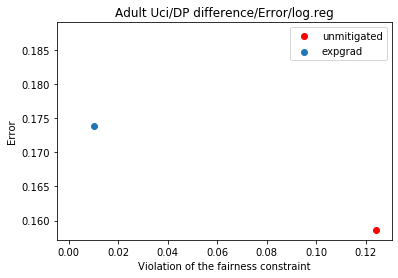

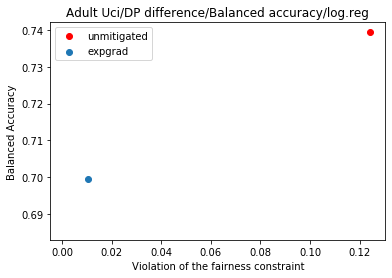

In [10]:
import matplotlib.pyplot as plt

plt.scatter(expgrad_violation_logistic,expgrad_error_logistic,label="expgrad")
plt.plot(violation_logistic,error_logistic,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/Error/log.reg')
plt.legend()
plt.show()

plt.scatter(expgrad_violation_logistic,expgrad_accuracy_logistic,label="expgrad")
plt.plot(violation_logistic,accuracy_logistic,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Balanced Accuracy')
plt.title('Adult Uci/DP difference/Balanced accuracy/log.reg')
plt.legend()
plt.show()

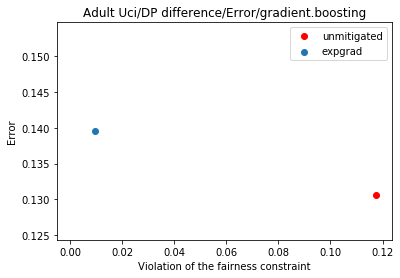

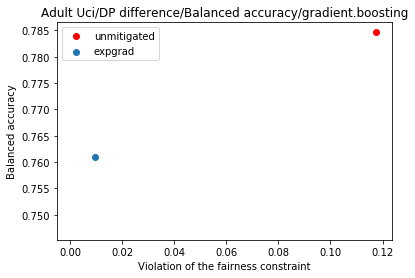

In [11]:
plt.scatter(expgrad_violation_ensemble,expgrad_error_ensemble,label="expgrad")
plt.plot(violation_ensemble,error_ensemble,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/Error/gradient.boosting')
plt.legend()
plt.show()

plt.scatter(expgrad_violation_ensemble,expgrad_accuracy_ensemble,label="expgrad")
plt.plot(violation_ensemble,accuracy_ensemble,'ro',label="unmitigated")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Balanced accuracy')
plt.title('Adult Uci/DP difference/Balanced accuracy/gradient.boosting')
plt.legend()
plt.show()

# Grid Search for Logistic Learner

In [12]:
lambda_vecs_logistic = (expgrad_X_logistic._lambda_vecs_LP)
# print(lambda_vecs_logistic)
keys = lambda_vecs_logistic.keys()

lambda_vec_logistic = lambda_vecs_logistic[keys[-1]]
print(lambda_vec_logistic)

sign  event  group_id
+     all    0           0.000000
             1           0.000000
-     all    0           0.231895
             1           0.000000
Name: 6, dtype: float64


In [13]:
grid_search_logistic=GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                        constraints=DemographicParity(),
                        grid_offset=lambda_vec_logistic)
a=datetime.now()  
grid_search_logistic.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
time_grid_search_logistic = (b-a).seconds

In [14]:
# Sanity check
print(grid_search_logistic._lambda_vecs)

                            0         1         2         3         4  \
sign event group_id                                                     
+    all   0         0.000000  0.000000  0.000000  0.000000  0.000000   
           1         0.000000  0.000000  0.000000  0.000000  0.000000   
-    all   0         0.231895  0.231895  0.231895  0.231895  0.231895   
           1         2.000000  1.600000  1.200000  0.800000  0.400000   

                            5         6         7         8         9  
sign event group_id                                                    
+    all   0         0.000000  0.000000  0.000000  0.000000  0.000000  
           1         0.000000  0.400000  0.800000  1.200000  1.600000  
-    all   0         0.231895  0.231895  0.231895  0.231895  0.231895  
           1         0.000000  0.000000  0.000000  0.000000  0.000000  


In [15]:
predictors = grid_search_logistic._predictors
grid_search_logistic_error = []
grid_search_logistic_violation = []
grid_search_logistic_accuracy = []

for predictor in predictors:
    grid_search_logistic_y = pd.Series(predictor.predict(X_train_all),name="grid_search_logistic_y")
    grid_search_logistic_error.append(get_error(y_train_all,grid_search_logistic_y))
    grid_search_logistic_violation.append(get_violation(grid_search_logistic_y,A_train_all,"grid_search_logistic_y"))
    grid_search_logistic_accuracy.append(get_balanced_accuracy_score(y_train_all,grid_search_logistic_y))

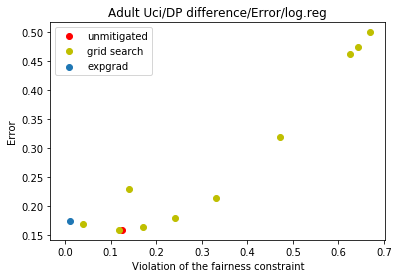

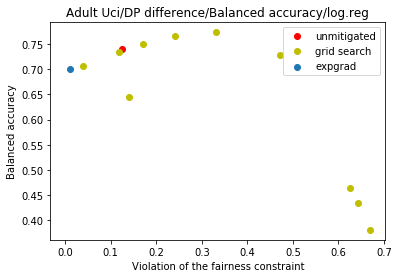

In [16]:
plt.scatter(expgrad_violation_logistic,expgrad_error_logistic,label="expgrad")
plt.plot(violation_logistic,error_logistic,'ro',label="unmitigated")
plt.plot(grid_search_logistic_violation,grid_search_logistic_error,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/Error/log.reg')
plt.legend()
plt.show()

plt.scatter(expgrad_violation_logistic,expgrad_accuracy_logistic,label="expgrad")
plt.plot(violation_logistic,accuracy_logistic,'ro',label="unmitigated")
plt.plot(grid_search_logistic_violation,grid_search_logistic_accuracy,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Balanced accuracy')
plt.title('Adult Uci/DP difference/Balanced accuracy/log.reg')
plt.legend()
plt.show()

In [17]:
print("The error and violation for all predictors:")
for i in range(len(grid_search_logistic_error)):
    print("  "+str(i)+": violation: ",str(grid_search_logistic_violation[i])+" error: "+str(grid_search_logistic_error[i]))

The error and violation for all predictors:
  0: violation:  0.4724200862951983 error: 0.319554067749762
  1: violation:  0.33014916339465844 error: 0.2143668806240595
  2: violation:  0.24056367085628394 error: 0.1789257086698811
  3: violation:  0.1701213001636365 error: 0.16393845397868612
  4: violation:  0.11918644454455182 error: 0.1588096188691993
  5: violation:  0.038488040291663875 error: 0.16857590368846165
  6: violation:  0.14072012887313184 error: 0.2286477688031694
  7: violation:  0.6255936227518328 error: 0.4611651976290655
  8: violation:  0.6430699302846964 error: 0.47434046865882495
  9: violation:  0.6692054912318417 error: 0.49918614293172814


In [18]:
grid_search_logistic_y = pd.Series(grid_search_logistic.predict(X_train),name="grid_search_logistic_y")
grid_search_logistic_error_best = get_error(y_train,grid_search_logistic_y)
grid_search_logistic_violation_best = get_violation(grid_search_logistic_y,A_train,"grid_search_logistic_y")

print("For the best one grid search choose:")
print("violation: ",str(grid_search_logistic_violation_best)+" error: "+str(grid_search_logistic_error_best))

For the best one grid search choose:
violation:  0.03584969034407237 error: 0.16984029484029484


# Grid Search for Gradient Boosting

In [19]:
lambda_vecs_ensemble = (expgrad_X_ensemble._lambda_vecs_LP)
# print(lambda_vecs)
keys = lambda_vecs_ensemble.keys()

lambda_vec_ensemble = lambda_vecs_ensemble[keys[-1]]
print(lambda_vec_ensemble)

sign  event  group_id
+     all    0           0.00000
             1           0.00000
-     all    0           0.27788
             1           0.00000
Name: 7, dtype: float64


In [20]:
grid_search_ensemble=GridSearch(GradientBoostingClassifier(),
                        constraints=DemographicParity(),
                        grid_offset=lambda_vec_ensemble)
a=datetime.now()
grid_search_ensemble.fit(X_train_all, y_train_all, sensitive_features=A_train_all)
b=datetime.now()
time_grid_search_ensemble = (b-a).seconds

In [21]:
# Sanity check
print(grid_search_logistic._lambda_vecs)

                            0         1         2         3         4  \
sign event group_id                                                     
+    all   0         0.000000  0.000000  0.000000  0.000000  0.000000   
           1         0.000000  0.000000  0.000000  0.000000  0.000000   
-    all   0         0.231895  0.231895  0.231895  0.231895  0.231895   
           1         2.000000  1.600000  1.200000  0.800000  0.400000   

                            5         6         7         8         9  
sign event group_id                                                    
+    all   0         0.000000  0.000000  0.000000  0.000000  0.000000  
           1         0.000000  0.400000  0.800000  1.200000  1.600000  
-    all   0         0.231895  0.231895  0.231895  0.231895  0.231895  
           1         0.000000  0.000000  0.000000  0.000000  0.000000  


In [22]:
predictors = grid_search_ensemble._predictors
grid_search_ensemble_error = []
grid_search_ensemble_violation = []
grid_search_ensemble_accuracy = []

for predictor in predictors:
    grid_search_ensemble_y = pd.Series(predictor.predict(X_train_all),name="grid_search_ensemble_y")
    grid_search_ensemble_error.append(get_error(y_train_all,grid_search_ensemble_y))
    grid_search_ensemble_violation.append(get_violation(grid_search_ensemble_y,A_train_all,"grid_search_ensemble_y"))
    grid_search_ensemble_accuracy.append(get_balanced_accuracy_score(y_train_all,grid_search_ensemble_y))

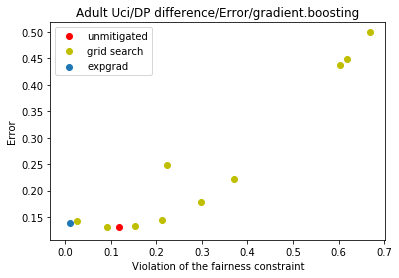

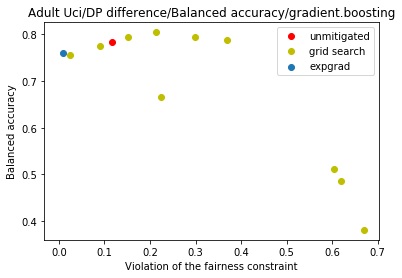

In [23]:
plt.scatter(expgrad_violation_ensemble,expgrad_error_ensemble,label="expgrad")
plt.plot(violation_ensemble,error_ensemble,'ro',label="unmitigated")
plt.plot(grid_search_ensemble_violation,grid_search_ensemble_error,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Error')
plt.title('Adult Uci/DP difference/Error/gradient.boosting')
plt.legend()
plt.show()

plt.scatter(expgrad_violation_ensemble,expgrad_accuracy_ensemble,label="expgrad")
plt.plot(violation_ensemble,accuracy_ensemble,'ro',label="unmitigated")
plt.plot(grid_search_ensemble_violation,grid_search_ensemble_accuracy,'yo',label="grid search")
plt.xlabel('Violation of the fairness constraint')
plt.ylabel('Balanced accuracy')
plt.title('Adult Uci/DP difference/Balanced accuracy/gradient.boosting')
plt.legend()
plt.show()

# Running time

In [24]:
print("Time for Expgrad:")
print("Logistic learner: ",time_expgrad_logistic)
print("Grad boosting learner: ",time_expgrad_ensemble)

Time for Expgrad:
Logistic learner:  22
Grad boosting learner:  32


In [25]:
print("Time for Grid Search:")
print("Logistic learner: ",time_grid_search_logistic)
print("Grad boosting learner: ",time_grid_search_ensemble)

Time for Grid Search:
Logistic learner:  28
Grad boosting learner:  34
